<img src="img/banner.png" alt="Deparatemento de Ingeniería de Sistemas y Computación, Universidad de los Andes">

# Exploración de una imagen

**Introducción**

El Open Data Cube es un conjunto de librerías **Python** que facilitan el proceso de **Organización**, **Consulta** y **Recuperación** de información de imágenes de satélite. Este notebook muestra el proceso de consulta y análisis básico de una imagen satelital mediante las funcionalidades que ofrece el ODC.

Estos análisis se realizan mediante comandos en el lenguaje Python que usan precisamente las funciones provistas por las librerías que hemos nombrado.

Los fundamentos de Python necesarios se encuentran en el notebook `1. Introducción a Python.ipynb` en el directorio notebooks base

**Objetivo**

El objetivo del presente notebook es familiarizarse con proceso de consulta de imágenes satelitales en el cubo de datos.

Vamos a conocer la estructura de matrices en la cuál el cubo de datos entrega los datos de imágenes satelitales y finalmente familiarizarse con el proceso de visualización de imágenes. 

**Contenido**

1. Instalar librerías de Python
2. importar librerías
3. Consulta del área de estudio
4. Características de la imágen obtenida
5. Aplicación de un algoritmo de análisis
6. Visualización de resultados

## 1. Instalar librerías de Python
___

Dado que el cubo se trabaja desde Python, se puede utilzar cualquiera de las librerías de Python ya existentes.

En esta sección instalaremos la librería `geopandas`, que nos permite en particular usar polígonos en formato KML (el de Google Earth) en Python. 

Para instalar una librería se usa el commando 

`pip3 install <nombre librería de python>`


In [1]:
!pip3 install geopandas

     |████████████████████████████████| 994 kB 1.4 MB/s eta 0:00:01     |██████████████▌                 | 450 kB 1.4 MB/s eta 0:00:01


**Una vez la libería es instalada es necesario reiniciar el Kernel de Jupyter. Para ello debe ir a la `barra de heramientas -> Kernel -> Restart Kernel...`. Luego en la opción `Restart`.**

## 2. Importar librerías
___
En esta sección se importan las librerías cuya funicionalidades particulares son requeridas.

In [32]:
# las funcionalidades del open data cube son accedidas 
# por medio de la librería datacube
import datacube

# Librería usada para la carga de polígonos
import geopandas as gpd

# Librería usada para visualización de datos
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

# Desactiva los warnings en el notebook
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Configuración de Drivers para leer polígonos en formato KML
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

## 2. Consulta del área de estudio
___

(Opción 1) Consultar un área a partir de un polígono

    latitude=(5.482742764560578, 5.599560141454585),
    longitude=(-72.98455102539063, -72.86891119384765),


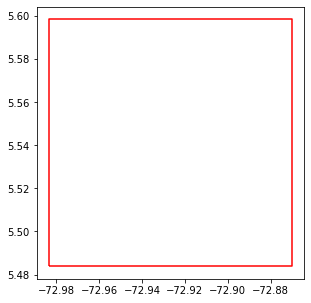

In [28]:
# Carga del archivo .kml y ponerlo en el sistema de coordenadas WGS 84 (EPSG 4326)
df_polygon = gpd.read_file("polygon/tota_lake.kml",driver='KML')
df_polygon = df_polygon.to_crs('EPSG:4326')

# Pintar el polígono seleccionado
fig, ax = plt.subplots(figsize=(5,5))
df_polygon.boundary.plot(ax=ax,color='red')

# Obtención de la geometría del polígono del GeoDataFrame
geometry_predio = df_polygon['geometry'][0]

# Obtención de los límites del cuadrado que enmarca el polígono
minx, miny, maxx, maxy = geometry_predio.bounds

# Aumento del aŕea del cuadrado para "EPSG:4326" (WGS84 - Unidades en grados)
# 0.001 grados que corresponden a 111 metros alrededor del polígono
buffer = 0.001

minx = minx - buffer
miny = miny - buffer
maxx = maxx + buffer
maxy = maxy + buffer

# Parámetros de área a ser consultada
set_study_area_lat = (miny,maxy)
set_study_area_lon = (minx,maxx)

print(f'    latitude={set_study_area_lat},')
print(f'    longitude={set_study_area_lon},')

(Opción 2) Consultar un área a partir de un punto

Los coordenadas del punto a seleccionar pueden ser obtenidas a través de herramientas GIS como google maps. Este punto debe estar comprendido en el área que se desea estudiar. El punto definido será empleado para la generación de un cuadrado que finalmente será usado para consultar el área de estudio. La variable `buffer` permite ampliar o disminuir las dimensiones del cuadrado. Lo anterior es equivalente a disminuir o ampliar el área de estudio a consultar en el open data cube.

<img src="img/latlong_buffer.png" alt="Definición área de estudio" width="20%">

In [4]:
# Definición de las coordenadas del punto
central_lat = 5.547964746532565
central_lon =  -72.9284962779124

# Aumento del aŕea del cuadrado para "EPSG:4326" (WGS 84 - Unidades en grados)
# 0.1 grados que corresponden a 11.1 kilómetros a partir del punto central
buffer = 0.1

# Cálculo del cuadro delimitador (bounding box) para el área de estudio
set_study_area_lat = (central_lat - buffer, central_lat + buffer)
set_study_area_lon = (central_lon - buffer, central_lon + buffer)

print(f'    latitude={set_study_area_lat},')
print(f'    longitude={set_study_area_lon},')

    latitude=(5.447964746532565, 5.647964746532565),
    longitude=(-73.0284962779124, -72.82849627791241),


Carga de información en el Open Data Cube

In [5]:
dc = datacube.Datacube(app="Cana")

dataset = dc.load(
    product="s2_sen2cor_ard_granule_EO3",
    latitude=(5.447964746532565, 5.647964746532565),
    longitude=(-73.0284962779124, -72.82849627791241),
    time=('2021-01-01', '2021-02-01'),
    measurements=["red","blue","green","nir","swir1","swir2","scl"],
    crs="EPSG:4326",
    output_crs="EPSG:4326",
    resolution=(-0.00008983111,0.00008971023)
)

dataset

<xarray.Dataset>
Dimensions:      (latitude: 2228, longitude: 2230, time: 1)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-30T17:40:15
  * latitude     (latitude) float64 5.648 5.648 5.648 ... 5.448 5.448 5.448
  * longitude    (longitude) float64 -73.03 -73.03 -73.03 ... -72.83 -72.83
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) uint16 297 123 156 ... 284 266 216
    blue         (time, latitude, longitude) uint16 111 42 98 123 ... 96 105 97
    green        (time, latitude, longitude) uint16 244 106 152 ... 364 340 289
    nir          (time, latitude, longitude) uint16 938 395 544 ... 2018 1888
    swir1        (time, latitude, longitude) uint16 855 855 428 ... 1455 1584
    swir2        (time, latitude, longitude) uint16 568 568 282 ... 718 718 820
    scl          (time, latitude, longitude) uint8 7 7 2 2 2 2 4 ... 4 4 4 4 4 4
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

## 3. Características de la imagen obtenida

La función `dc.load` del open datacube recibe una consulta y retorna una estructura de datos llamada `xarray.Dataset` que contiene toda la información que fue solicitada en la consulta. Un `xarray.Dataset` presenta las siguientes propiedades.

<img src="https://raw.githubusercontent.com/MINE-Coursera/GEO_M4_DataCube/Desarrollo/notebooks%20ODC/img/xarray.png" alt="xarray.Dataset" width="60%">

**Dimensiones (`Dimensions`)**

Las dimensiones identifican el número de pasos de tiempo devueltos en la búsqueda (`time: 4`), así como el número de píxeles en las dimensiones `latitude` y `longitude`. Además, indica cómo están organizados los datos en las diferentes dimensiones.

**Coordenadas (`Coordinates`)**

* `time` identifica la fecha atribuida a cada intervalo de tiempo devuelto como resultado de la consulta.
* `latitude` y `longitude` son las coordenadas de cada píxel dentro de los límites espaciales de la consulta.

<img src="https://raw.githubusercontent.com/DonAurelio/open-datacube-bac-training/main/docs/numpy_array_shape.png" alt="xarray.Dataset" width="60%">

**Variables de datos (`Data variables`)**

Por cada banda (*measurement*) que representa la información espectral de la imágen hay una *variable de datos*. En el ejemplo anterior, las variables de datos obtenidas son: `red`,`blue`,`green`,`nir`,`swir1`,`swir2`,`scl`. Cada variable de datos es un arreglo de tres dimensiones de tipo `xarray.DataArray`.

**Atributos (`Attributes`)**

* `crs` identifica el sistema de coordenadas de referencia de la imagen obtenida.


### Exploración de las dimensiones

La propiedad `dims` permite visualizar las dimensiones dle dataset.

In [6]:
dataset.dims

Frozen(SortedKeysDict({'time': 1, 'latitude': 2228, 'longitude': 2230}))

> **TODO:** ¿Cuántos periodos de tiempo retornó la consulta? ¿Cuántos píxeles retorno la consulta?

### Exploración de las coordenadas

La propiedad `coords`permite visualizar las coordenadas. Las coordenadas pueden ser vistas como las etiquetas de los ejes de un cubo de tres dimensiones. En este caso, las dimensiones son `time`, `longitude`, `latitude`.

In [7]:
dataset.coords

Coordinates:
  * time         (time) datetime64[ns] 2021-01-30T17:40:15
  * latitude     (latitude) float64 5.648 5.648 5.648 ... 5.448 5.448 5.448
  * longitude    (longitude) float64 -73.03 -73.03 -73.03 ... -72.83 -72.83
    spatial_ref  int32 4326

Para conocer de forma explícita los periodos de tiempo retornados como resultado de la consulta

In [8]:
dataset.coords['time']

<xarray.DataArray 'time' (time: 1)>
array(['2021-01-30T17:40:15.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2021-01-30T17:40:15
    spatial_ref  int32 4326
Attributes:
    units:    seconds since 1970-01-01 00:00:00

Para conocer de forma explícita las coordendas de longitud

In [9]:
dataset.coords['longitude']

<xarray.DataArray 'longitude' (longitude: 2230)>
array([-73.028478, -73.028388, -73.028299, ..., -72.828693, -72.828604,
       -72.828514])
Coordinates:
  * longitude    (longitude) float64 -73.03 -73.03 -73.03 ... -72.83 -72.83
    spatial_ref  int32 4326
Attributes:
    units:       degrees_east
    resolution:  8.971023e-05
    crs:         EPSG:4326

Para conocer de forma explícita las coordendas de latitud

In [10]:
dataset.coords['latitude']

<xarray.DataArray 'latitude' (latitude: 2228)>
array([5.647996, 5.647906, 5.647817, ..., 5.448122, 5.448032, 5.447942])
Coordinates:
  * latitude     (latitude) float64 5.648 5.648 5.648 ... 5.448 5.448 5.448
    spatial_ref  int32 4326
Attributes:
    units:       degrees_north
    resolution:  -8.983111e-05
    crs:         EPSG:4326

### Exploración de las variables de datos

La información espectral de una imagen satelital está organizada por el Open Data Cube en *variables de datos*. 

Cada variable de datos contiene la información de una única banda. 

La información de cada banda es organizada en un arreglo de tres dimensiones. 

Para acceder a la información espectral de la banda `blue` se puede usar la expresión mostrada a continuación.

In [11]:
dataset.blue

<xarray.DataArray 'blue' (time: 1, latitude: 2228, longitude: 2230)>
array([[[111,  42,  98, ..., 317, 337, 370],
        [223, 108, 145, ..., 318, 335, 372],
        [316, 259, 283, ..., 356, 336, 358],
        ...,
        [292, 301, 313, ..., 138, 100,  69],
        [305, 350, 332, ..., 119, 139,  84],
        [348, 340, 315, ...,  96, 105,  97]]], dtype=uint16)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-30T17:40:15
  * latitude     (latitude) float64 5.648 5.648 5.648 ... 5.448 5.448 5.448
  * longitude    (longitude) float64 -73.03 -73.03 -73.03 ... -72.83 -72.83
    spatial_ref  int32 4326
Attributes:
    units:         reflectance
    nodata:        0
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

Dado que cada variable de datos es un arreglo de tres dimensiones, es posible indexar la información del mismo. Es importante conocer el orden de los ejes para determinar de antemano la información que se muestra al indexar una variable de datos.

Por ejemplo, puedo obtener la primera imágen en el tiempo para la banda `blue`. 

In [12]:
dataset.blue[0]

<xarray.DataArray 'blue' (latitude: 2228, longitude: 2230)>
array([[111,  42,  98, ..., 317, 337, 370],
       [223, 108, 145, ..., 318, 335, 372],
       [316, 259, 283, ..., 356, 336, 358],
       ...,
       [292, 301, 313, ..., 138, 100,  69],
       [305, 350, 332, ..., 119, 139,  84],
       [348, 340, 315, ...,  96, 105,  97]], dtype=uint16)
Coordinates:
    time         datetime64[ns] 2021-01-30T17:40:15
  * latitude     (latitude) float64 5.648 5.648 5.648 ... 5.448 5.448 5.448
  * longitude    (longitude) float64 -73.03 -73.03 -73.03 ... -72.83 -72.83
    spatial_ref  int32 4326
Attributes:
    units:         reflectance
    nodata:        0
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

En la mayoría de los casos es deseable visualizar los valores en la banda blue para la imagen seleccionada para un periodo de tiempo. A continuación, se muestra cómo obtener una imágen para la banda `blue` para un periodo de tiempo seleccionado.

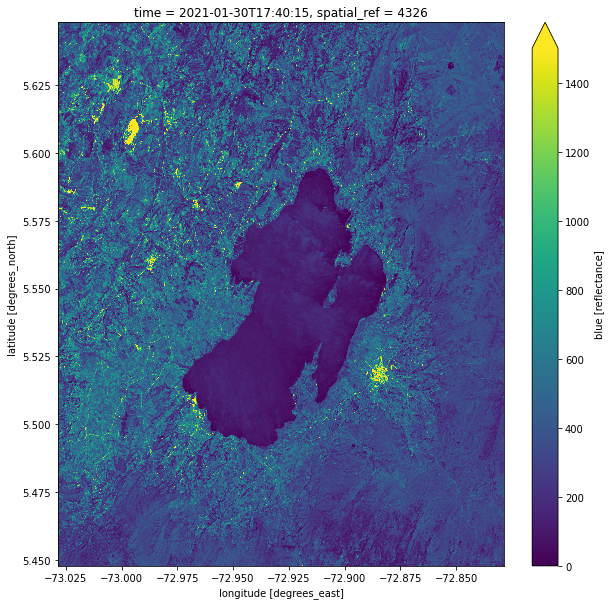

In [45]:
# Los valores de las bandas en Sentinel 2 estan en el rango [0,10000]. vmin y vmax se usa solo para propósitos de visualiación. 
# es decir, para ajustar la escala de colores. Los valores de los píxeles que son mayores a 1500, serán igual a 1500. 
# Por otro lado, aquellos que son menores que 0 serán igual al cero
dataset.blue[0].plot(vmin=0,vmax=1500)

De la misma forma, se puede ver el valor para la banda `blue` de un único píxel. Los valores entre corchetes `[0,0,0]` se interpretan considerando el orden de las coordenadas. En este caso:

* la primera coordenada es el tiempo (`time`) de modo que en la matrix se ha seleccionado el periodo de tiempo `0`. 
* la segúnda coodenada es la latitud (`latitude`) de modo que en la matrix se ha selccionado la latitud `0`
* la tercera coordenada es la longitud (`longitude`) así, la longitud seleccionada es `0`

In [17]:
dataset.blue[0,0,0]

<xarray.DataArray 'blue' ()>
array(111, dtype=uint16)
Coordinates:
    time         datetime64[ns] 2021-01-30T17:40:15
    latitude     float64 5.648
    longitude    float64 -73.03
    spatial_ref  int32 4326
Attributes:
    units:         reflectance
    nodata:        0
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

> **TODO:**  Realice el proceso de **Exploración de variables de datos** para las variables (bandas) restantes `red`,`green`,`nir`,`swir1`,`swir2` y `scl`. Cree una nueva celda para cada ejemplo. Puede apoyarse en el ejemplo de exploración de la banda `blue` mostrado anteriormente.

### Exploración de atributos

Entre los atributos que hacen parte de los metadatos de la imagen, se muestra el sistema de referencia de coordenadas (CRS) de la imagen obtenida a partir del Open Data Cube. Una de las bondades del Open Data Cube es que permite obtener la información de las imágenes en diferentes sistemas de coordendas y en diferentes dimensiones.

In [18]:
dataset.crs

'EPSG:4326'

## 5. Visualización de resultados

La visualización es uno de los procesos más importantes en el proceso de análisis de una imágen satelital. El open data cube facilita en todos los aspectos el análisis de series de tiempo. Es decir cómo cambia la información espectral mostrada por la cobertura terrestre en el tiempo. A continuación aprenderemos a desarrollar diferentes tipos de visualizaciones para las imágenes obtenidas a partir de una consulta. 

Imágen en `true color`

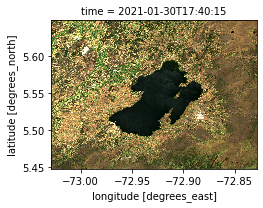

In [36]:
rgb = dataset[["red","green","blue"]].to_array(dim='color')
rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
img = rgb.plot.imshow(col='time',col_wrap=4,add_colorbar=False,vmin=0,vmax=1500)

Imágen en `true color` con el polígono que se empleó para delimitar el área de consulta

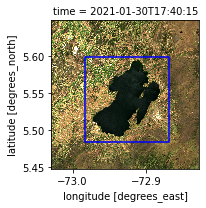

In [25]:
rgb = dataset[["red","green","blue"]].to_array(dim='color')
rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
img = rgb.plot.imshow(col='time',col_wrap=4,add_colorbar=False,vmin=0,vmax=1500)

for axes in img.axes.flat:
    df_polygon.boundary.plot(ax=axes,markersize=20,color='blue',marker='o')
plt.show()

Cambio en el tiempo de la información espectral únicamente de la banda `red`.

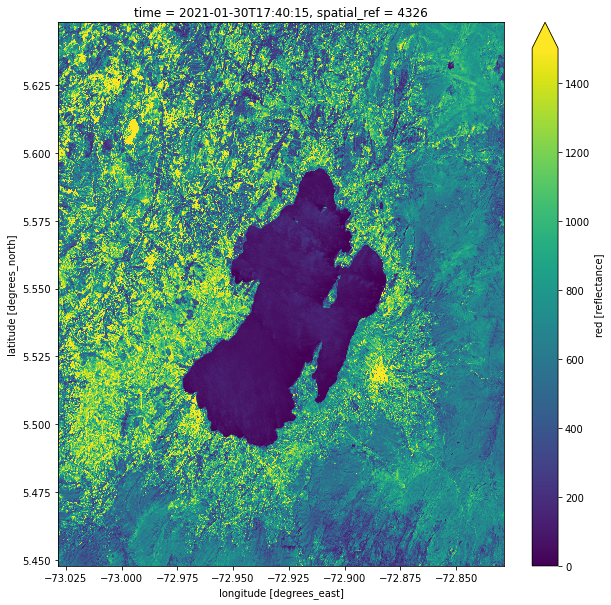

In [47]:
#dataset.red[0].plot(col='time',col_wrap=4,vmin=0,vmax=1500)
dataset.red[0].plot(col_wrap=4, vmin=0,vmax=1500)

Para cambiar el rango de colores de la visualización mostrada usamos el parámetro `cmap` y le indicamos un rango de color válido. El listado de colores válidos lo puede encontrar [aquí](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)

In [23]:
dataset.red.plot(col='time',col_wrap=4,cmap='Reds',vmin=0,vmax=1500)

ValueError: IndexVariable objects must be 1-dimensional

Cambio en el tiempo de la información espectral únicamente de la banda `blue`.

In [22]:
dataset.blue.plot(col='time',col_wrap=4, cmap='Blues',vmin=0,vmax=1500)

ValueError: IndexVariable objects must be 1-dimensional

> **TODO:**  Realice el proceso de **Visualización** para las variables (bandas) restantes `green`,`nir`,`swir1`,`swir2` y `scl`. Cree una nueva celda para cada ejemplo. Puede apoyarse en el ejemplo de exploración de la banda `blue` mostrado anteriormente. Use los colores `'Greens'` para la banda `green`; para las demás bandas no cambie los colores.